In [1]:
# Data visualization
import matplotlib.pyplot as plt

# Data manipulation
import pandas as pd
import numpy as np

# Vector representations and embeddings
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import gensim

# Modeling - Logistic, XGBOOST, SVM
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

In [2]:
import sys
sys.path.append(f'../../../python')

from balance_split_data import create_label, balance_unique_id, \
create_balanced_excluded, create_train_test_excluded, group_by_case, create_feature_label

from grid_search import gridsearch, fit_best_model_train, evaluate, fit_best_model_test, get_feature_importance_cv

from ml_model import train_model_cross_val, train_model_test, get_feature_importance, get_feature_importance10, eval_matrix

### Load data

In [3]:
df = pd.read_json(r"../../../../data/processed/pre-processed_merged_2023_04_04.json")
random_seed=42
random_state=42

### Balance data and split to train and test set

In [4]:
label_name = "phase2"

In [5]:
df1 = create_label(df, label_name)
df_unique = balance_unique_id(df1)
df_balanced_unique, df_balanced, df_excluded = create_balanced_excluded(df_unique, df1, random_seed=42)
df_train, df_test, df_test1 = create_train_test_excluded(df_balanced, df_balanced_unique, df_excluded, random_state=42)
df_train_grouped, df_test_grouped, df_test1_grouped, df_excluded_grouped = group_by_case(df_train, df_test, df_test1, df_excluded)

Total decisions: 1583
0    1485
1      98
Name: label, dtype: int64
Balancing...
Total decisions: 196
Labels distribution: 
 0    98
1    98
Name: 0, dtype: int64
Training set shape: (157,) (157,)
Test set shape: (40,) (40,)
Creating df_train 1: 78 0: 79
Creating df_test1 1: 20 0: 20
Creating df_test concatenated with df_excluded with len: 1386
Creating df_test 1: 20 0: 1406
Grouping df_train by case_num 1: 78 0: 79
Grouping df_test by case_num 1: 20 0: 1406
Grouping df_test1 by case_num 1: 20 0: 20
Grouping df_excluded by case_num with len: 1386


In [6]:
X_train, y_train, X_test, y_test, X_test1, y_test1, X_test2, y_test2 = create_feature_label(df_train_grouped, df_test_grouped, df_test1_grouped, df_excluded_grouped)

### Model training (with 10-fold CV) using best parameters from GridSearch

In [7]:
# for param_name in sorted(parameters.keys()):
#         print("\t%s: %r" % (param_name, best_parameters[param_name]))

# 	clf__C: 0.1
# 	tfidf__binary: True
# 	tfidf__max_df: 0.05
# 	tfidf__ngram_range: (1, 2)
# 	tfidf__norm: 'l2'
# 	tfidf__use_idf: False

In [8]:
vec = ('wordvec', TfidfVectorizer(analyzer = 'word', max_features=5000, lowercase=False, stop_words=None, \ 
                                  ngram_range = (1,2), binary = True, max_df = 0.05, norm = 'l2', use_idf = False))
c = 0.1
# solver = 'liblinear'
model=LinearSVC(C=c)

In [9]:
df_metrics = pd.DataFrame(columns = ['set', 'tn', 'fp', 'fn', 'tp', 'recall', 'precision', 'f_score', 'fpr', 'accuracy', 'roc_auc'])

In [10]:
# balanced train
pipeline_train, trained_model, y_predict_train = train_model_cross_val(X_train, y_train, vec=vec, model=model, cv=10)
set = "balanced train"
metrics_train=evaluate(y_train, y_predict_train)
row_train = pd.DataFrame({'set':set, 'tn':metrics_train[0], 'fp':metrics_train[1], 'fn':metrics_train[2], 'tp':metrics_train[3], \
                    'recall':metrics_train[4], 'precision':metrics_train[5], 'f_score':metrics_train[6], \
                    'fpr':metrics_train[7], 'accuracy':metrics_train[8], 'roc_auc':metrics_train[9]}, index=[0])


# balanced test
pipeline_test1, y_predict_test1 = train_model_test(X_train, y_train, X_test1, y_test1, model=model, vec=vec)
set = "balanced test"
metrics_test1=evaluate(y_test1, y_predict_test1)
row_test1 = pd.DataFrame({'set':set, 'tn':metrics_test1[0], 'fp':metrics_test1[1], 'fn':metrics_test1[2], 'tp':metrics_test1[3], \
                        'recall':metrics_test1[4], 'precision':metrics_test1[5], 'f_score':metrics_test1[6], \
                        'fpr':metrics_test1[7], 'accuracy':metrics_test1[8], 'roc_auc':metrics_test1[9]}, index=[0])


# imbalanced test
pipeline_test, y_predict_test = train_model_test(X_train, y_train, X_test, y_test, model=model, vec=vec)
set = "imbalanced test"
metrics_test=evaluate(y_test, y_predict_test)
row_test = pd.DataFrame({'set':set, 'tn':metrics_test[0], 'fp':metrics_test[1], 'fn':metrics_test[2], 'tp':metrics_test[3], \
                    'recall':metrics_test[4], 'precision':metrics_test[5], 'f_score':metrics_test[6], \
                    'fpr':metrics_test[7], 'accuracy':metrics_test[8], 'roc_auc':metrics_test[9]}, index=[0])

df_metrics = pd.concat([df_metrics.loc[:], row_train, row_test1, row_test]).reset_index(drop=True)
df_metrics['n'] = df_metrics['tn'] + df_metrics['fp'] + df_metrics['fn'] + df_metrics['tp']

***10-fold cross-validation***
Accuracy: 0.8726114649681529

Classification report:
               precision    recall  f1-score   support

           0       0.83      0.94      0.88        79
           1       0.93      0.81      0.86        78

    accuracy                           0.87       157
   macro avg       0.88      0.87      0.87       157
weighted avg       0.88      0.87      0.87       157


CR: (0.8789656311962988, 0.8722005842259006, 0.871983039791259, None)

Confusion matrix:
 [[74  5]
 [15 63]] 

_______________________


 Accuracy: 87.261 
 Precision: 0.926 
 Recall: 0.808 
 F1: 0.863 
 FPR: 0.063 
 ROC_AUC: 0.872
Accuracy: 0.8726114649681529

Classification report:
               precision    recall  f1-score   support

           0       0.83      0.94      0.88        79
           1       0.93      0.81      0.86        78

    accuracy                           0.87       157
   macro avg       0.88      0.87      0.87       157
weighted avg       0.88      

In [11]:
df_metrics

,set,tn,fp,fn,tp,recall,precision,f_score,fpr,accuracy,roc_auc,n
0,balanced train,74,5,15,63,0.807692,0.926471,0.863014,0.063291,87.261146,0.872201,157
1,balanced test,20,0,4,16,0.800000,1.000000,0.888889,0.000000,90.000000,0.900000,40
2,imbalanced test,1325,81,4,16,0.800000,0.164948,0.273504,0.057610,94.039271,0.871195,1426


In [13]:
df_metrics.to_excel('../../../../output/tables/svm_metrics_p2.xlsx', index=True)

### Confusion matrix and model performance

In [14]:
merger_info = pd.read_json(r"../../../../data/processed/merger_info_2023_03_25.json")

In [15]:
results_train, tn, fp, fn, tp = eval_matrix(df_train_grouped, merger_info, X_train, y_train, y_predict_train)

In [16]:
results1, tn, fp, fn, tp = eval_matrix(df_test1_grouped, merger_info, X_test1, y_test1, y_predict_test1)

In [17]:
results2, tn, fp, fn, tp = eval_matrix(df_test_grouped, merger_info, X_test, y_test, y_predict_test)

In [18]:
print("TN:", len(tn))
print("FP:", len(fp))

print("FN:", len(fn))
print("TP:", len(tp))

TN: 1325
FP: 81
FN: 4
TP: 16


In [19]:
tn['nace_code'].value_counts().head(10)

Manufacture of basic pharmaceutical products and pharmaceutical preparations                                          38
Telecommunications                                                                                                    38
Manufacture of chemicals and chemical products                                                                        35
Manufacture of other parts and accessories for motor vehicles                                                         23
Financial service activities, except insurance and pension funding                                                    17
Computer programming, consultancy and related activities                                                              13
Manufacture of pharmaceutical preparations                                                                            12
Manufacture of basic chemicals, fertilisers and nitrogen compounds, plastics and synthetic rubber in primary forms    12
Manufacture of parts and accesso

In [20]:
fp['nace_code'].value_counts().head(10)

Manufacture of medical and dental instruments and supplies                                                                                    5
Telecommunications                                                                                                                            4
Manufacture of basic pharmaceutical products and pharmaceutical preparations                                                                  2
Manufacture of chemicals and chemical products                                                                                                2
Television programming and broadcasting activities; Wired telecommunications activities; Wireless telecommunications activities               2
Manufacture of basic chemicals, fertilisers and nitrogen compounds, plastics and synthetic rubber in primary forms                            2
Pre-press and pre-media services                                                                                                        

In [21]:
fn['nace_code'].value_counts().head(10)

Electric power generation, transmission and distribution; Manufacture of gas; distribution of gaseous fuels through mains    1
Sound recording and music publishing activities                                                                              1
Manufacture of railway locomotives and rolling stock                                                                         1
Electricity, gas, steam and air conditioning supply; Retail sale of automotive fuel in specialised stores                    1
Name: nace_code, dtype: int64

In [22]:
tp['nace_code'].value_counts().head(10)

Printing and service activities related to printing                                                                                                                                                                                                                                                                                                                                                                                                         1
Computer programming, consultancy and related activities; Construction of residential and non-residential buildings; Construction of water projects; Electrical installation; Manufacture of electric motors, generators and transformers; Manufacture of electricity distribution and control apparatus; Manufacture of engines and turbines, except aircraft, vehicle and cycle engines; Manufacture of other electronic and electric wires and cables    1
Warehousing and storage                                                                                     

### Feature importance

In [23]:
df_features_train, feature_importance, feature_names = get_feature_importance(trained_model, pipeline_train)
df_features_train.head(10)

,feature,importance,abs_importance
2436,lead horizontally,-0.146497,0.146497
52,achieve community,-0.143744,0.143744
4373,spain germany,0.131202,0.131202
1611,electricity retail,-0.130769,0.130769
658,committee concentration,0.122421,0.122421
1612,electricity sector,-0.118813,0.118813
2706,market electricity,-0.114313,0.114313
4951,wide wider,-0.112787,0.112787
1141,dairy product,-0.112463,0.112463
3036,opinion advisory,0.111708,0.111708


Get features for label = 1 and label = 0

In [24]:
df_features_train1, df_features_train0 = get_feature_importance10(df_features_train)

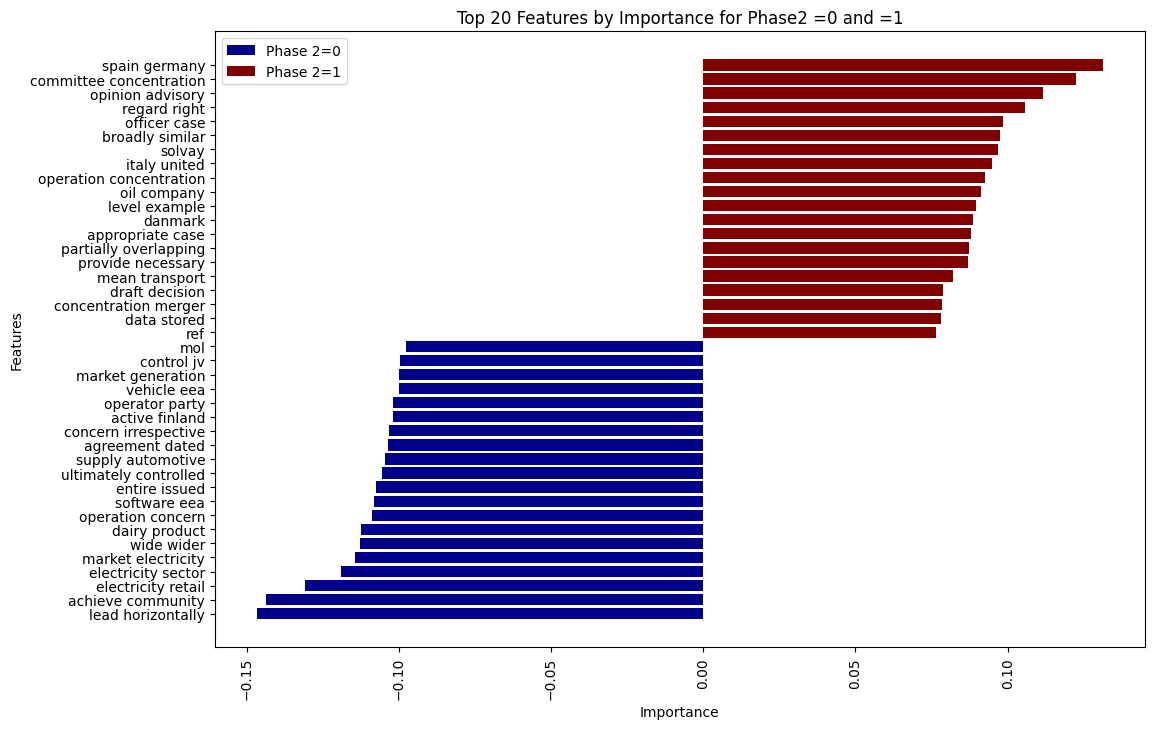

In [25]:
# Sort the features by absolute importance for label=1
df_features_train1 = df_features_train1.sort_values(by='abs_importance', ascending=False)
df_features_train1_top10 = df_features_train1.nlargest(20, 'abs_importance')
df_features_train1_top10 = df_features_train1_top10.sort_values('importance', ascending=True)

# Sort the features by absolute importance for label=0
df_features_train0 = df_features_train0.sort_values(by='abs_importance', ascending=False)
df_features_train0_top10 = df_features_train0.nlargest(20, 'abs_importance')

# Create a combined bar chart
fig, ax = plt.subplots(figsize=(12, 8))
ax.barh(df_features_train0_top10['feature'], df_features_train0_top10['importance'], color='darkblue', label='Phase 2=0')
ax.barh(df_features_train1_top10['feature'], df_features_train1_top10['importance'], color='maroon', label='Phase 2=1')
ax.set_xlabel('Importance')
ax.set_ylabel('Features')
ax.set_title('Top 20 Features by Importance for Phase2 =0 and =1')
ax.legend()
plt.xticks(rotation=90)
# plt.show()

plt.savefig('../../../../output/figures/svm_full_p2.png', bbox_inches='tight')

In [26]:
df_features_train.to_excel('../../../../output/tables/features_svm_train_full_p2.xlsx', index=True)